## Importing necessary libraries:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt  #data visualization
%matplotlib inline
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_union

Using TensorFlow backend.


Loading training and testing data in pandas dataframe:

In [2]:
data = pd.read_csv('train.csv')

Train-test split:

In [3]:
cut_point = int(data.shape[0]*0.70)
train = data[:cut_point]
test = data[cut_point:]

In [6]:
print(train.shape)
print(test.shape)

(111699, 8)
(47872, 8)


## Our dataset:

In [4]:
print("Shape of training data:",train.shape,'\n')

print("First 15 entries of our dataset:")
train.head(16)

Shape of training data: (111699, 8) 

First 15 entries of our dataset:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_text = train['comment_text']
test_text = test['comment_text']
y_train = train[classes].values
y_test = test[classes].values

# Data Preprocessing and Visualization:

Checking for null values:

In [6]:
print("null values in training data:\n\n",train.isnull().any(),'\n')
print("null values in testing data:\n\n",test.isnull().any(),'\n')

null values in training data:

 id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool 

null values in testing data:

 id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool 



Understanding the comments in our training data:

In [7]:
print(train.comment_text.str.len().describe())

count    111699.000000
mean        395.684581
std         594.898991
min           6.000000
25%          96.000000
50%         205.000000
75%         436.000000
max        5000.000000
Name: comment_text, dtype: float64


Adding a column for non-toxic comments in the training data:

In [8]:
train['non_toxic'] = 1 - train[train.columns[2:]].max(axis =1)


/home/siddhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
x = train.iloc[:,2:].sum()
print('total number of comments:',len(train),'\n','number of comments belonging to each class','\n',x)

total number of comments: 111699 
 number of comments belonging to each class 
 toxic             10735
severe_toxic       1104
obscene            5924
threat              342
insult             5521
identity_hate       956
non_toxic        100318
dtype: int64


In [10]:
train['toxic_any'] = train[train.columns[2:8]].max(axis =1)

/home/siddhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
x = train.iloc[:,2:].sum()
print('total number of comments:',len(train),'\n','number of comments belonging to each class','\n',x)

total number of comments: 111699 
 number of comments belonging to each class 
 toxic             10735
severe_toxic       1104
obscene            5924
threat              342
insult             5521
identity_hate       956
non_toxic        100318
toxic_any         11381
dtype: int64


Barplot for the class-distribution of comments in training data:

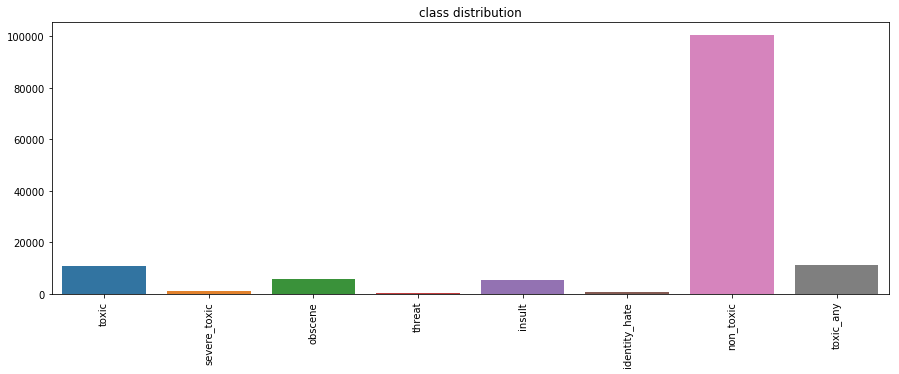

In [12]:
plt.figure(figsize=(15,5))
sns.barplot(x.index,x.values)
plt.xticks(rotation=90)
plt.title('class distribution')
plt.show()

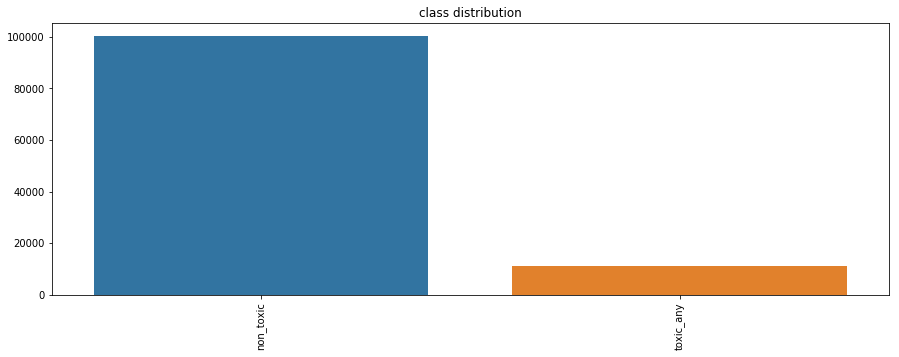

In [13]:
x_new = train.iloc[:,8:].sum()
plt.figure(figsize=(15,5))
sns.barplot(x_new.index,x_new.values)
plt.xticks(rotation=90)
plt.title('class distribution')
plt.show()

Tokenizing the comments:

In [14]:
max_features = 30000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_text))
list_tokenized_train = tokenizer.texts_to_sequences(train_text)
list_tokenized_test = tokenizer.texts_to_sequences(test_text)

Comments in tokenized form:

In [15]:
print(list_tokenized_train[:10])

[[695, 74, 1, 124, 130, 177, 29, 676, 4606, 12526, 1082, 86, 332, 51, 2281, 10875, 50, 7097, 15, 60, 2701, 146, 7, 2943, 34, 117, 1183, 13293, 2740, 4, 45, 59, 247, 1, 394, 32, 1, 37, 27, 145, 73, 3588, 89, 2969, 4372, 2169, 1034], [52, 2749, 13, 537, 3662, 73, 4919, 2702, 21, 93, 37, 821, 2750, 1002, 571, 9571, 182], [414, 437, 73, 135, 14, 250, 2, 71, 318, 77, 50, 9, 13, 617, 8, 2326, 486, 509, 101, 4, 599, 2, 36, 328, 124, 368, 3, 29, 37, 27, 52, 205, 2, 476, 57, 35, 1, 2433, 94, 1, 723, 466], [57, 7, 238, 97, 55, 334, 1439, 15, 2088, 7, 6442, 22, 1, 126, 2422, 56, 16, 512, 15, 25, 5, 4021, 3, 1339, 3, 9726, 7, 67, 1, 278, 85, 122, 13294, 38, 9, 51, 18, 42, 10, 1, 1487, 138, 1245, 2143, 433, 1245, 307, 7, 39, 33, 9, 512, 15, 22, 46, 48, 327, 103, 112, 22, 6, 19, 55, 4373, 12, 2433, 275, 15, 278, 25, 107, 2, 33, 11, 199, 45, 268, 36, 69, 41, 548, 2, 16, 5, 5970, 15, 81, 12, 398, 38, 7, 637, 41, 85, 16, 5, 2054, 379, 5, 3069, 3207, 76, 77, 418, 10, 1, 509, 640, 3608, 28, 98, 23, 3577,

Histogram to visualize the distribution of number of words in each comment:

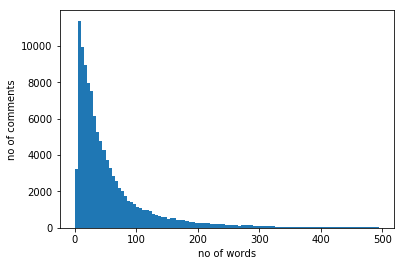

In [16]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,500,5))
plt.xlabel("no of words")
plt.ylabel("no of comments")
plt.show()

## Training Model:

For training Machine Learning models, simple tokenizing and word counts are a good starting point, but are very basic.

One issue with simple counts is that some words like “the”,"a","is" etc appear many times and their large counts do not add any meaning to the model.

An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document Frequency" which are the components of the resulting scores assigned to each word.

Converting the comments into a matrix of TF-IDF features.

In [18]:
word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',
                                  token_pattern=r'\w{1,}',ngram_range=(1, 1),max_features=30000)
char_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='char',
                                  ngram_range=(1, 4),max_features=30000)
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=2)


In [19]:
vectorizer.fit(train_text)
train_features = vectorizer.transform(train_text)
test_features = vectorizer.transform(test_text)

Training Logistic Regression model on the processed data:

In [21]:
scores = []
output = pd.DataFrame.from_dict({'id': test['id']})
for class_name in classes:
    train_target = train[class_name]
    model = LogisticRegression(solver='sag')

    cv_score = np.mean(cross_val_score(model, train_features, train_target, cv=5))
    scores.append(cv_score)
    print('cross-validation score for class {} is {}'.format(class_name, cv_score))

    model.fit(train_features, train_target)
    output[class_name] = model.predict_proba(test_features)[:, 1]

print('Total average cross-validation score is {}'.format(np.mean(scores)))

output.to_csv('output.csv', index=False)

cross-validation score for class toxic is 0.9612530073443464
cross-validation score for class severe_toxic is 0.9906982112490358
cross-validation score for class obscene is 0.9797849616291456
cross-validation score for class threat is 0.9971441116278659
cross-validation score for class insult is 0.9729720426802777
cross-validation score for class identity_hate is 0.9925872168373571
Total average cross-validation score is 0.9824065918946715


Predicted probabilities for toxicity of each class in our output:

In [22]:
output.head(16)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
111699,55858b89f99e9bda,0.408584,0.008519,0.030557,0.004674,0.095810,0.056625
111700,5586a218c2393d06,0.019948,0.006419,0.012636,0.004116,0.008238,0.008014
111701,5588be8efb4c1515,0.010491,0.001994,0.008307,0.000891,0.023052,0.005272
111702,558a1f3d0f4fcc03,0.097678,0.000496,0.013722,0.000503,0.025351,0.003099
111703,558e22e3c617327e,0.002245,0.000548,0.002298,0.000272,0.001762,0.001099
111704,558e293118141536,0.024911,0.001523,0.005579,0.000846,0.006014,0.000603
111705,558ea55c7fd61f0b,0.995618,0.123617,0.987926,0.008621,0.653525,0.022797
111706,559148ab67cff41d,0.004609,0.000686,0.002326,0.000363,0.001692,0.001047
111707,55943f89019b8090,0.034346,0.001789,0.007145,0.000964,0.014858,0.005800
111708,5597b5b3b1b54cdb,0.017425,0.001171,0.005543,0.001277,0.006316,0.000851


Converting probabilities into 0/1 using appropriate threshold value:

In [23]:
for class_name in classes:
    output[class_name][output[class_name] > 0.6] = 1
    output[class_name][output[class_name] <= 0.6] = 0

/home/siddhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/siddhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Updated output:

In [24]:
output.head(16)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
111699,55858b89f99e9bda,0.0,0.0,0.0,0.0,0.0,0.0
111700,5586a218c2393d06,0.0,0.0,0.0,0.0,0.0,0.0
111701,5588be8efb4c1515,0.0,0.0,0.0,0.0,0.0,0.0
111702,558a1f3d0f4fcc03,0.0,0.0,0.0,0.0,0.0,0.0
111703,558e22e3c617327e,0.0,0.0,0.0,0.0,0.0,0.0
111704,558e293118141536,0.0,0.0,0.0,0.0,0.0,0.0
111705,558ea55c7fd61f0b,1.0,0.0,1.0,0.0,1.0,0.0
111706,559148ab67cff41d,0.0,0.0,0.0,0.0,0.0,0.0
111707,55943f89019b8090,0.0,0.0,0.0,0.0,0.0,0.0
111708,5597b5b3b1b54cdb,0.0,0.0,0.0,0.0,0.0,0.0


Accuracy on testing data:

In [25]:
list_accuracy = []
for class_name in classes:
    score = accuracy_score(test[class_name], output[class_name])
    print('Accuracy score for class {}:'.format(class_name), score )
    list_accuracy.append(score)

avg_score = sum(list_accuracy)/len(list_accuracy)
print('Total average accuracy score testing data:',avg_score )

Accuracy score for class toxic: 0.9598930481283422
Accuracy score for class severe_toxic: 0.9905790441176471
Accuracy score for class obscene: 0.9787349598930482
Accuracy score for class threat: 0.997576871657754
Accuracy score for class insult: 0.9719669117647058
Accuracy score for class identity_hate: 0.9917906082887701
Total average accuracy score testing data: 0.981756907308378


In [26]:
import pickle
train_target = train['toxic']
model = LogisticRegression(solver='sag')
model.fit(train_features, train_target)

pickle.dump(model, open('model.pkl','wb'))


In [25]:
import pickle

train_target = train['toxic_any']
model = LogisticRegression(solver='sag')

cv_score = np.mean(cross_val_score(model, train_features, train_target, cv=5))
print('cross-validation score for class toxic_any is {}'.format(cv_score))

model.fit(train_features, train_target)
pickle.dump(model, open('model.pkl','wb'))

cross-validation score for class toxic_any is 0.9604114618633333


In [54]:
sentence = 'you are an ass hole'
t1= vectorizer.transform([sentence])
print(t1)

  (0, 1829)	0.2574349745337738
  (0, 2278)	0.22701388655802276
  (0, 2486)	0.5779516526678348
  (0, 13005)	0.7209897664014966
  (0, 29752)	0.16833767587634743
  (0, 30161)	0.11668196342035014
  (0, 30611)	0.1175190375999698
  (0, 30723)	0.0741490920852968
  (0, 30724)	0.13139801709859908
  (0, 30742)	0.08929834126946175
  (0, 30746)	0.11369297758982479
  (0, 30754)	0.10579495479223198
  (0, 30760)	0.19007148353817552
  (0, 31293)	0.07166498739020062
  (0, 31339)	0.12796251158496375
  (0, 31342)	0.2421143545000874
  (0, 36192)	0.10408736598331532
  (0, 37156)	0.06037367167197893
  (0, 37158)	0.09471053231050269
  (0, 37163)	0.14955103909536213
  (0, 37412)	0.06889736088381271
  (0, 37486)	0.10495005945750963
  (0, 37487)	0.11205672752666447
  (0, 37592)	0.07297321280823399
  (0, 37672)	0.15932718709521887
  :	:
  (0, 50457)	0.08430324037868957
  (0, 51072)	0.10612405953036858
  (0, 51105)	0.19914577120901372
  (0, 51932)	0.06231950746610724
  (0, 51933)	0.08881857330949915
  (0, 51936)	

In [55]:
model = pickle.load(open('model.pkl','rb'))
print(model.predict(t1))

[1]


In [26]:
pickle.dump(vectorizer, open('vectorizer.pkl','wb'))

vectorizer = pickle.load(open('vectorizer.pkl','rb'))

In [28]:
import pickle
model = pickle.load(open('model.pkl','rb'))
vectorizer = pickle.load(open('vectorizer.pkl','rb'))
scores = []
output = pd.DataFrame.from_dict({'id': test['id']})
train_target = train['toxic_any']
o = model.predict(test_features)
score = accuracy_score(test['toxic_any'], o)
print('Accuracy score :', score )

Accuracy score : 0.9618357286096256


In [26]:
test['toxic_any'] = test[test.columns[2:8]].max(axis =1)

/home/siddhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_any
111699,55858b89f99e9bda,Hope he dies \n\nNow this Atheist filth's wife...,1,0,0,1,1,0,1
111700,5586a218c2393d06,What do you mean? Could you explain your point...,0,0,0,0,0,0,0
111701,5588be8efb4c1515,"""\nWell, the finals are just as popular(maybe ...",0,0,0,0,0,0,0
111702,558a1f3d0f4fcc03,User: Johnleemk Please Stop vandalizing wiki u...,0,0,0,0,0,0,0
111703,558e22e3c617327e,Greg's Apology\n\nA while back I added Greg's ...,0,0,0,0,0,0,0
111704,558e293118141536,Talk Pretty One Day|Me,0,0,0,0,0,0,0
111705,558ea55c7fd61f0b,Fap \nSo I herd u were still a FUCKING WANKER....,1,1,1,0,0,0,1
111706,559148ab67cff41d,We know from this diff that she is the Communi...,0,0,0,0,0,0,0
111707,55943f89019b8090,Manning benched \n\nManning was benched on 11/...,0,0,0,0,0,0,0
111708,5597b5b3b1b54cdb,"""\n\nNo original research\n\nYou can add your ...",0,0,0,0,0,0,0
